In [1]:
import shutil
import os
import datetime

import numpy as np
from scipy.linalg import inv, eigvals, norm
import matplotlib.pyplot as plt
import cvxpy as cp
from tqdm import tqdm
from joblib import Parallel, delayed
from multiprocessing import Manager

from utils import *
from models.tvgti_pc_nonsparse import TimeVaryingSEM as TimeVaryingSEM_PC_NONSPARSE
from models.tvgti_pp_nonsparse_undirected import TimeVaryingSEM as TimeVaryingSEM_PP_NONSPARSE_UNDIRECTED

In [2]:
def generate_random_S(N, sparsity, max_weight):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(i + 1, N):
            if np.random.rand() < sparsity:
                weight = np.random.uniform(-max_weight, max_weight)
                # weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
                S[j, i] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)

    S = S / norm(S)
    return S

def generate_random_S_with_off_diagonal(N, sparsity, max_weight):
    S = np.zeros((N, N))
    
    for i in range(N):
        for j in range(N):
            if i != j and np.random.rand() < sparsity:
                weight = np.random.uniform(-max_weight, max_weight)
                # weight = np.random.uniform(0, max_weight)
                S[i, j] = weight
    
    # Ensure spectral radius < 1
    spectral_radius = max(abs(eigvals(S)))
    if spectral_radius >= 1:
        S = S / (spectral_radius + 0.1)

    S = S / norm(S)
    return S

def modify_S(S, edge_indices, factor=2.0):
    S_modified = S.copy()
    for (i, j) in edge_indices:
        if i != j:
            S_modified[i, j] *= factor
            S_modified[j, i] *= factor
    return S_modified

def generate_stationary_X(N, T, S_is_symmetric, sparsity, max_weight, std_e):
    if S_is_symmetric:
        S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
    else:
        S = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X, e_t_series

def generate_stationary_X_from_S(S, N, T, std_e):
    S = S
    S_series = [S for _ in range(T)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S = inv(I - S)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X = inv_I_S @ e_t_series

    return S_series, X

def generate_piecewise_X(N, T, S_is_symmetric, sparsity, max_weight, std_e):
    max_weight_0 = max_weight
    max_weight_1 = max_weight
    if S_is_symmetric:
        S0 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
    else:
        S0 = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
    # S1 = generate_random_S(N, sparsity=sparsity, max_weight=max_weight_1)
    S1 = S0*2
    S_series = [S0 for _ in range(T // 2)] + [S1 for _ in range(T - T // 2)]
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    I = np.eye(N)
    try:
        inv_I_S0 = inv(I - S0)
        inv_I_S1 = inv(I - S1)
    except np.linalg.LinAlgError:
        raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    X0 = inv_I_S0 @ e_t_series[:, :T // 2]
    X1 = inv_I_S1 @ e_t_series[:, T // 2:]
    X = np.concatenate([X0, X1], axis=1)

    return S_series, X

def generate_piecewise_X_K(N, T, S_is_symmetric, sparsity, max_weight, std_e, K):
    S_list = []
    inv_I_S_list = []
    I = np.eye(N)

    for i in range(K):
        if S_is_symmetric:
            S = generate_random_S(N, sparsity=sparsity, max_weight=max_weight)
        else:
            S = generate_random_S_with_off_diagonal(N, sparsity=sparsity, max_weight=max_weight)
        S_list.append(S)
        try:
            inv_I_S = inv(I - S)
            inv_I_S_list.append(inv_I_S)
        except np.linalg.LinAlgError:
            raise ValueError("The matrix (I - S) is non-invertible. Please adjust S to ensure invertibility.")

    # Divide T into K segments
    segment_lengths = [T // K] * K
    segment_lengths[i-1] += T % K

    # Create S_series
    S_series = []
    for i, length in enumerate(segment_lengths):
        S_series.extend([S_list[i]] * length)

    # Generate error terms
    e_t_series = np.random.normal(0, std_e, size=(N, T))

    # Compute X
    X_list = []
    start = 0
    for i, length in enumerate(segment_lengths):
        end = start + length
        X_i = inv_I_S_list[i] @ e_t_series[:, start:end]
        X_list.append(X_i)
        start = end

    X = np.concatenate(X_list, axis=1)

    return S_series, X


def solve_offline_sem(X_up_to_t, lambda_reg):
    N, t = X_up_to_t.shape
    S = cp.Variable((N, N), symmetric=True)
    
    # objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro') + lambda_reg * cp.norm1(S)
    objective = (1/(2*t)) * cp.norm(X_up_to_t - S @ X_up_to_t, 'fro')
    
    constraints = [cp.diag(S) == 0]
    
    prob = cp.Problem(cp.Minimize(objective), constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("CVXPY did not find an optimal solution.")
    
    S_opt = S.value
    return S_opt


In [3]:
plt.rc('text',usetex=True)
plt.rc('font',family="serif")
plt.rcParams["font.family"] = "Times New Roman"      #全体のフォントを設定
plt.rcParams["xtick.direction"] = "in"               #x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"               #y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.minor.visible"] = True          #x軸補助目盛りの追加
plt.rcParams["ytick.minor.visible"] = True          #y軸補助目盛りの追加
plt.rcParams["xtick.major.width"] = 1.5              #x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.5              #y軸主目盛り線の線幅
plt.rcParams["xtick.minor.width"] = 1.0              #x軸補助目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 1.0              #y軸補助目盛り線の線幅
plt.rcParams["xtick.major.size"] = 10                #x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10                #y軸主目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
plt.rcParams["font.size"] = 15                       #フォントの大きさ

pp_nonsparse: 100%|██████████| 20000/20000 [00:03<00:00, 6471.94it/s]


result_N10_T20000_maxweight0.5_variancee0.005_K4_SissymmetricTrue_seed30_P1_C1_gammma0.999_alpha0.015_betapc0.015_betaco0.02_betasgd0.02_r4_q10_rho0.15_mu_lambda1.5_timestamp20250120_164325.png


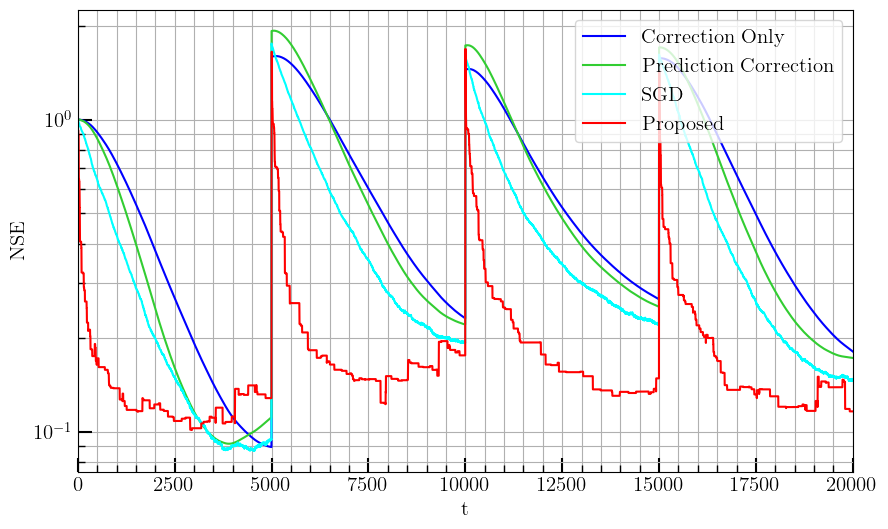

Notebook file copied to: ./result/250120/images/notebook_backup_20250120_164325.ipynb


In [4]:
#----------------------------------------------------
# メソッドごとの実行スイッチ
run_pc_flag = True     # Prediction Correction
run_co_flag = True     # Correction Only
run_sgd_flag = True    # SGD
run_pp_flag = True     # Proposed
#----------------------------------------------------

# パラメータの設定
N = 10
T = 20000
sparsity = 100
max_weight = 0.5
variance_e = 0.005
std_e = np.sqrt(variance_e)
K = 4
S_is_symmetric = True

seed = 30
np.random.seed(seed)

# TV-SEMシミュレーション
S_series, X = generate_piecewise_X_K(N, T, S_is_symmetric, sparsity, max_weight, std_e, K)

# オンラインTV-SEMパラメータ
P = 1
C = 1
gamma = 0.999
alpha = 0.015
beta_pc = 0.015
beta_co = 0.02
beta_sgd = 0.02

# 初期値の設定
if S_is_symmetric:
    S_0 = generate_random_S(N, sparsity, max_weight)
else:
    S_0 = generate_random_S_with_off_diagonal(N, sparsity, max_weight)

S_0 = S_0 / norm(S_0)

# その他のパラメータ
r = 4  # window size
q = 10  # number of processors
rho = 0.15# 試行回数の設定
mu_lambda = 1.5

# モデルのインスタンス化
tv_sem_pc = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_pc, gamma, P, C)
tv_sem_co = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_co, gamma, 0, C)
tv_sem_sgd = TimeVaryingSEM_PC_NONSPARSE(N, S_0, alpha, beta_sgd, 0, 0, C)
tv_sem_pp = TimeVaryingSEM_PP_NONSPARSE_UNDIRECTED(N, S_0, r, q, rho, mu_lambda)

# 実行関数の定義
def run_tv_sem_pc():
    estimates_pc, cost_values_pc = tv_sem_pc.run(X)
    return estimates_pc, cost_values_pc

def run_tv_sem_co():
    estimates_co, cost_values_co = tv_sem_co.run(X)
    return estimates_co, cost_values_co

def run_tv_sem_sgd():
    estimates_sgd, cost_values_sgd = tv_sem_sgd.run(X)
    return estimates_sgd, cost_values_sgd

def run_tv_sem_pp():
    estimates_pp = tv_sem_pp.run(X)
    return estimates_pp

#----------------------------------------------------
# ここで実行対象の関数だけリストを作る
# (関数と手法名をまとめて管理するとあとで集計しやすい)
job_list = []
if run_pc_flag:
    job_list.append(delayed(run_tv_sem_pc)())
if run_co_flag:
    job_list.append(delayed(run_tv_sem_co)())
if run_sgd_flag:
    job_list.append(delayed(run_tv_sem_sgd)())
if run_pp_flag:
    job_list.append(delayed(run_tv_sem_pp)())

results = Parallel(n_jobs=4)(job_list)
#----------------------------------------------------

# それぞれの結果を受け取る格納リスト
# （実行しないメソッドは空のままにする）
estimates_pc = []
cost_values_pc = []
estimates_co = []
cost_values_co = []
estimates_sgd = []
cost_values_sgd = []
estimates_pp = []

# 実行した順番に応じて results から取り出す
idx_result = 0

if run_pc_flag:
    estimates_pc, cost_values_pc = results[idx_result]
    idx_result += 1

if run_co_flag:
    estimates_co, cost_values_co = results[idx_result]
    idx_result += 1

if run_sgd_flag:
    estimates_sgd, cost_values_sgd = results[idx_result]
    idx_result += 1

if run_pp_flag:
    estimates_pp = results[idx_result] if run_pp_flag else []
    # すでに idx_result が並列実行数に達したらこの後は不要
    # （ただし if run_pp_flag: の条件内なので安全）
    idx_result += 1

# ここから結果の解析・可視化
# （実行したメソッドだけ処理をする）
S_opts = []
NSE_pc = []
NSE_co = []
NSE_sgd = []
NSE_pp = []
error_pc = []
error_co = []
error_sgd = []
error_pp = []

sum_error_pc = []
sum_error_co = []
sum_error_sgd = []
sum_error_pp = []

# PC
if run_pc_flag:
    for i, estimate in enumerate(estimates_pc):
        error_val = (norm(estimate - S_series[i]) ** 2) / (norm(S_0 - S_series[i]) ** 2)
        error_pc.append(error_val)
        sum_error_pc.append((estimate - S_series[i]).sum())

# Correction Only
if run_co_flag:
    for i, estimate in enumerate(estimates_co):
        error_val = (norm(estimate - S_series[i]) ** 2) / (norm(S_0 - S_series[i]) ** 2)
        error_co.append(error_val)
        sum_error_co.append((estimate - S_series[i]).sum())

# SGD
if run_sgd_flag:
    for i, estimate in enumerate(estimates_sgd):
        error_val = (norm(estimate - S_series[i]) ** 2) / (norm(S_0 - S_series[i]) ** 2)
        error_sgd.append(error_val)
        sum_error_sgd.append((estimate - S_series[i]).sum())

# Proposed
if run_pp_flag:
    for i, estimate in enumerate(estimates_pp):
        error_val = (norm(estimate - S_series[i]) ** 2) / (norm(S_0 - S_series[i]) ** 2)
        error_pp.append(error_val)
        sum_error_pp.append((estimate - S_series[i]).sum())

# 結果のプロット
plt.figure(figsize=(10,6))

# Correction Only
if run_co_flag:
    plt.plot(error_co, color='blue', label='Correction Only')
# Prediction Correction
if run_pc_flag:
    plt.plot(error_pc, color='limegreen', label='Prediction Correction')
# SGD
if run_sgd_flag:
    plt.plot(error_sgd, color='cyan', label='SGD')
# Proposed
if run_pp_flag:
    plt.plot(error_pp, color='red', label='Proposed')

plt.yscale('log')
plt.xlim(left=0, right=T)
plt.xlabel('t')
plt.ylabel('NSE')
plt.grid(True, "both")
plt.legend()

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

filename = (
    f'result_N{N}_'
    f'T{T}_'
    f'maxweight{max_weight}_'
    f'variancee{variance_e}_'
    f'K{K}_'
    f'Sissymmetric{S_is_symmetric}_'
    f'seed{seed}_'
    f'P{P}_'
    f'C{C}_'
    f'gammma{gamma}_'
    f'alpha{alpha}_'
    f'betapc{beta_pc}_'
    f'betaco{beta_co}_'
    f'betasgd{beta_sgd}_'
    f'r{r}_'
    f'q{q}_'
    f'rho{rho}_'
    f'mu_lambda{mu_lambda}_'
    f'timestamp{timestamp}.png'
)

print(filename)
today_str = datetime.datetime.now().strftime('%y%m%d')
save_path = f'./result/{today_str}/images'
os.makedirs(save_path, exist_ok=True)  # ディレクトリが無い場合は作成
plt.savefig(os.path.join(save_path, filename))
plt.show()

notebook_filename = "sandbox_parallel.ipynb"  # ★使用中のNotebook名を入力
copy_ipynb_path = os.path.join(save_path, f"notebook_backup_{timestamp}.ipynb")

shutil.copy(notebook_filename, copy_ipynb_path)
print(f"Notebook file copied to: {copy_ipynb_path}")
